# Location Classification
The goal of this notebook is to find important lab tests per location of (positive) uveitis patients. 
The hypothesis is that an anterior inflammation can be identified by a different subset of lab tests as for example posterior inflammations. 
This would allow to order a subset of all possible lab tests after the location of the inflammation has been located to identify uveitis. One approach would be to train a model per location.

Steps:

1. Get Subset of Data (Target Featue: Location, Input Features: Lab Results) 
2. Define suitable Algorithms for Binary Classification (e.g. Logistic Regression, etc.)
3. Call preprocessing pipe with appropriat parameters for the current algorithm
4. Fit Model
5. Extract and Discuss important Features

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, precision_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import plot_confusion_matrix


# import of pipe module
os.chdir('../preprocessing/')
import pipe

os.chdir('../machine_learning/')
import helpers


RANDOM = 43
# SCORER = make_scorer(f1_score, average='macro')
SCORER = make_scorer(balanced_accuracy_score)
def SCORE(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

def get_feature_names(pipeline_object):
    num_feat = pipeline_object[0].transformers_[0][2]
    try:
        one_hot_feat = pipeline_object[0].transformers_[1][1]['onehot'].get_feature_names(categorical_features)
    except:
        return X.columns
    return list(num_feat) + list(one_hot_feat)

def plot_featureimportance(pipeline_object):
    a = pd.DataFrame()
    a['value'] = pipeline_object[1].feature_importances_
    a['feature'] = get_feature_names(pipeline_object)
    a = a.sort_values(by='value', ascending=False)
    plt.figure(figsize=(10,7))
    g = sns.barplot(y=a.feature, x=a.value*100, data= a, color = 'steelblue')
    helpers.plot_wrapper(g, 'Feature Importances', None, 'Percentage', 'Feature Name')

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [2]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

gender           loc  calcium  lactate_dehydrogenase  \
0    Male      anterior     2.27                    184   
1  Female  intermediate     2.32                    209   
2  Female    panuveitis     2.44                    194   
3  Female      anterior     2.45                    156   
4  Female      anterior     2.28                    175   

   c-reactive_protein,_normal_and_high_sensitivity   wbc   rbc  hemoglobin  \
0                                             1.83  6.91  4.97        14.6   
1                                             0.15  4.24  4.22        11.0   
2                                            0.137  6.38  4.31        13.6   
3                                              3.5  5.24  4.82        14.6   
4                                              1.0  8.31  4.72        14.0   

   hematocrit   mcv  ...  lysozyme,_plasma  anti-ccp_ab  anti-ena_screen  \
0        41.4  83.3  ...               3.0          0.0              0.0   
1        36.0  85.3  ...              <NA>          0.0              0.0   
2        38.7  89.8  ...               4.8          0.0              0.0   
3        43.6  90.5  ...              <NA>          0.0              0.0   
4        40.7  86.2  ...               4.5          0.0              0.0   

   antinuclear_antibody  dna_double-stranded_ab  rheumatoid_factor  hbc__ab  \
0                   0.0                     0.0                  0        0   
1                   0.0                     0.0                  0        0   
2                   0.0                     0.0                  0        0   
3                   0.0                     0.0                  0        0   
4                   0.0                     1.0                  0        0   

   hbs__ag  hcv__ab  uveitis  
0        0        0    False  
1        0        0     True  
2        0        0     True  
3        0        0     True  
4        0        0     True  

[5 rows x 27 columns]

### Split into uveitis and not_uveitis data

In [3]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

# Multiclass classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the binary classification (see next chapter)

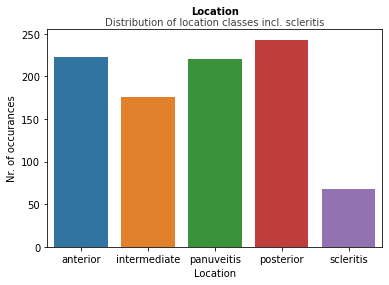

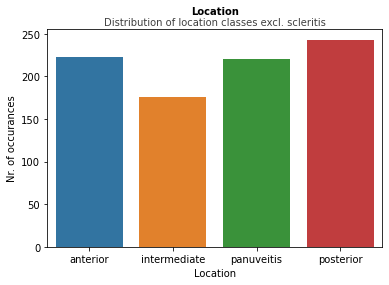

In [4]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes incl. scleritis','Location','Nr. of occurances')

# remove category scleritis
df_uv_pos_clean = df_uv_pos_clean[df_uv_pos_clean['loc'] != 'scleritis']
df_uv_pos_clean['loc'] = df_uv_pos_clean['loc'].cat.remove_unused_categories()

g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes excl. scleritis','Location','Nr. of occurances')

**Discussion** The target feature contains 5 classes. The three missing values have been removed. We can see that, with the execption of the location 'scleritis', that the classes are somewhat balanced. We remove the records with location 'scleritis' as upsampling or downsampling is not an option for this dataset. Because it is a minority class, it can negatively impact the prediction for every other class.

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

We pose the hypothesis that splitting the data into a male and female subset yields better results for the machine learning algorithmns. Thus we create 3 datasets. One containing all records with uveitits `X`, one containing only the male data `X_m` (the `m` stands for "male") and one containing only the female data `X_f` (the `f`stands for "female")

In [5]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

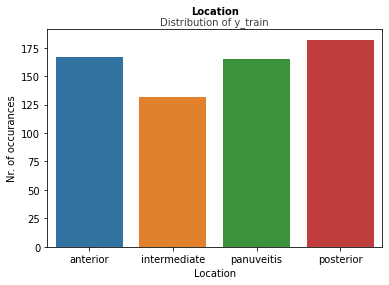

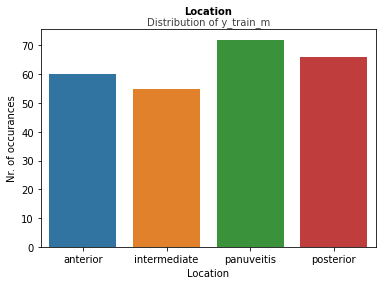

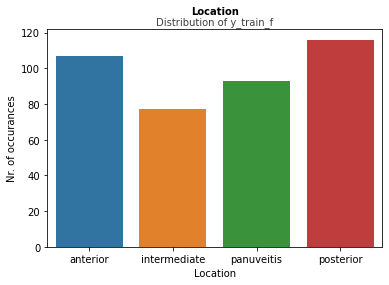

In [6]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

**Discussion** The three countplots show the distribution of the target feature for after the train-test Split for the whole dataset and the male/female datasets.

#### Imputation and Encoding

In [7]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_no_onehot # imputer_encoder_onehot yields best results so far 

We test multiple strategies for imputing missing values and encoding the data for later use with machine learning algorithms:

1. No OneHotEncoding of categorical features, categories will be Label Encoded. (with LabelEncoder), strategy for imputation: 
    Categorical Features: Most Frequent, Numerical Features: Median value.
2. OneHotEncoding of categorical features, strategy for imputation:
    Same as in Number 1
3. OneHotEncoding and imputation of missing values with a KNN Algorithmn.
4. No OneHotEncoding and imputation of missing values with a KNN Algorithmn.

## 3-Dimensional Data Representation

In [8]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train.values,
                   title="PCA representation of uveitits positive training data", labels={"0":"PC1","1":"PC2","2":"PC3"}, opacity=1,
                   width=800, height=800, size_max=.5)
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.71 %


In [9]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_m)

fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_m.values,
                   title="PCA representation of uveitits positive training data (male only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.64 %


In [10]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_f)

fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_f.values,
                   title="PCA representation of uveitits positive training data (female only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.26 %


The graphics above represent all three datasets in the first 3 Principal Components. We retain about 40% of the variance for all 3 datasets. We see hardly any distinguishable clusters in the data. It seems that the data will be hard to classify.

## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [11]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.2427227485629125
Class probabilites: [0.25851393 0.20433437 0.25541796 0.28173375]


### Male positive data

In [12]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.3286682615629984
Class probabilites: [0.23715415 0.2173913  0.28458498 0.26086957]


### Female positive data

In [13]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.2544216983733113
Class probabilites: [0.27226463 0.19592875 0.23664122 0.29516539]


## Decision Tree

### Complete positive data

Score: 0.27405391739408136
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': 18, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.40      0.34      0.37        56
intermediate       0.26      0.23      0.24        44
  panuveitis       0.19      0.22      0.21        55
   posterior       0.28      0.31      0.29        61

    accuracy                           0.28       216
   macro avg       0.28      0.27      0.28       216
weighted avg       0.29      0.28      0.28       216

Standarddeviation Score: 0.021232145864892846


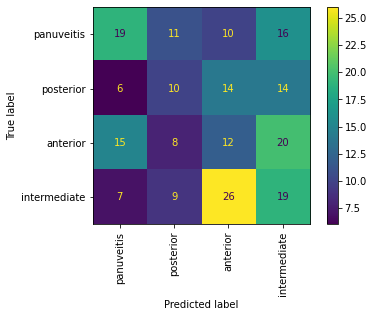

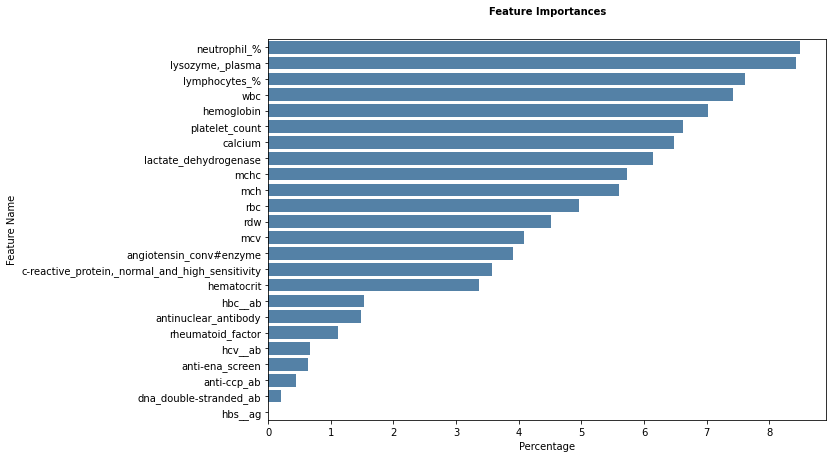

In [14]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.30148524720893144
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 4, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'best'}
              precision    recall  f1-score   support

    anterior       0.33      0.25      0.29        20
intermediate       0.25      0.32      0.28        19
  panuveitis       0.31      0.46      0.37        24
   posterior       0.36      0.18      0.24        22

    accuracy                           0.31        85
   macro avg       0.32      0.30      0.30        85
weighted avg       0.32      0.31      0.30        85

Standarddeviation Score: 0.047609150194360655


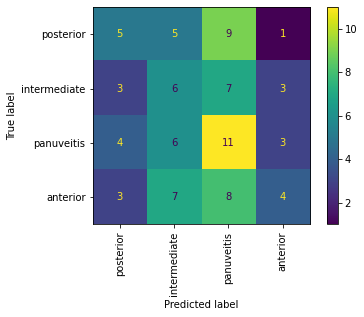

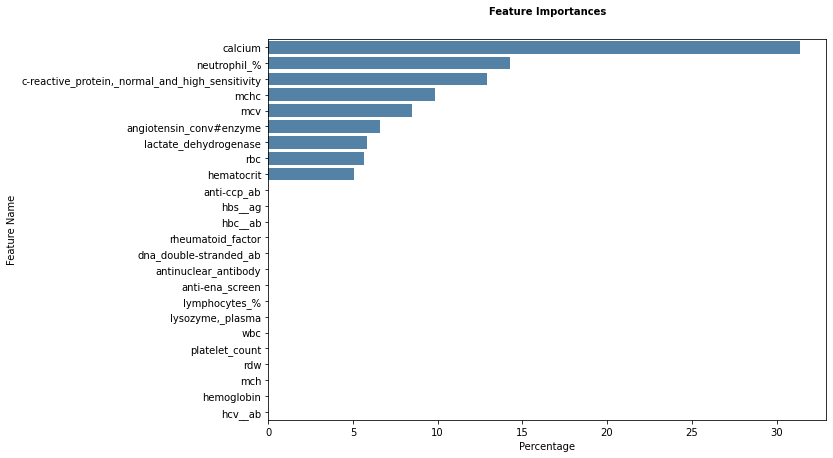

In [15]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.24941273779983458
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 18, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.39      0.33      0.36        36
intermediate       0.15      0.24      0.18        25
  panuveitis       0.19      0.19      0.19        31
   posterior       0.32      0.23      0.27        39

    accuracy                           0.25       131
   macro avg       0.26      0.25      0.25       131
weighted avg       0.28      0.25      0.26       131

Standarddeviation Score: 0.03201550056727531


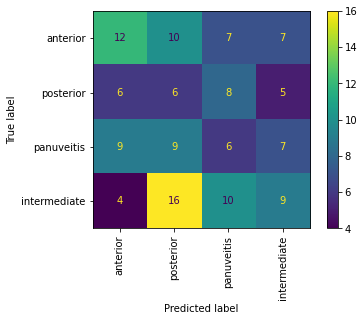

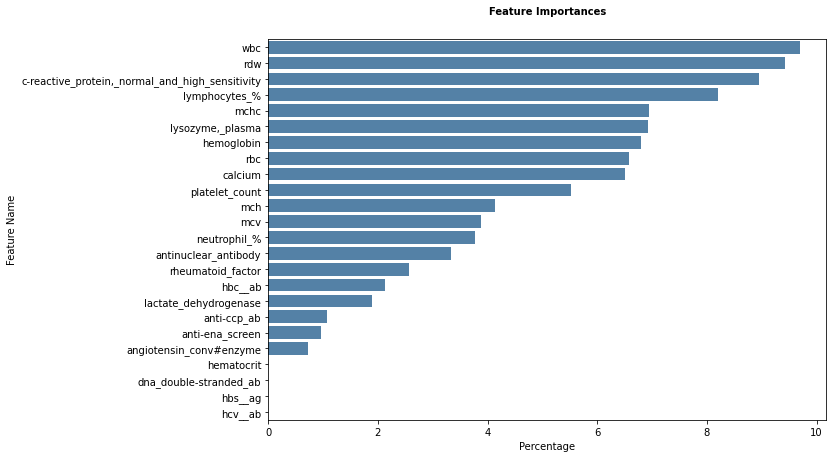

In [16]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.2790038854588035
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.30      0.30      0.30        56
intermediate       0.22      0.16      0.18        44
  panuveitis       0.26      0.31      0.28        55
   posterior       0.34      0.34      0.34        61

    accuracy                           0.29       216
   macro avg       0.28      0.28      0.28       216
weighted avg       0.28      0.29      0.28       216

Standarddeviation Score: 0.004699385283860087


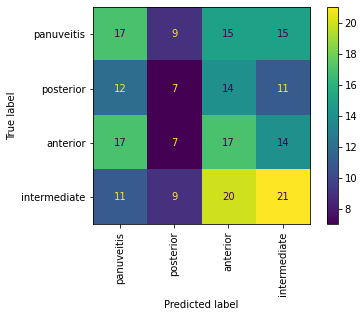

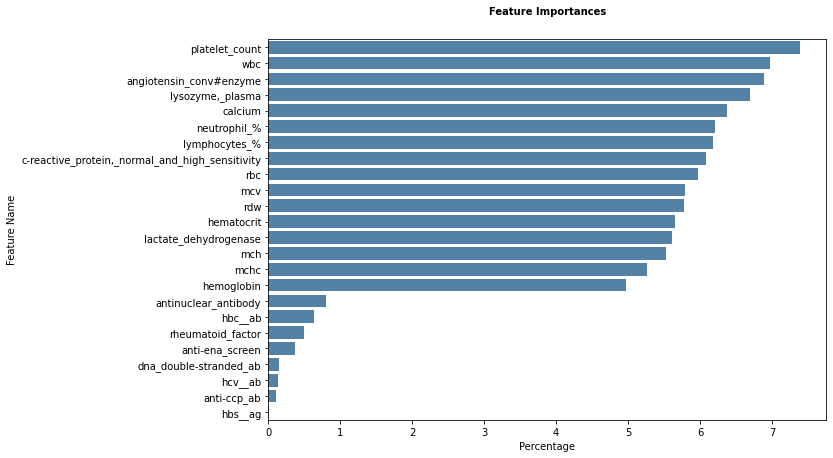

In [17]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    plot_featureimportance(bv.best_estimator_)

    
ran_tree(X_train, X_test, y_train, y_test)

In [18]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.26682615629984047
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.22      0.10      0.14        20
intermediate       0.26      0.32      0.29        19
  panuveitis       0.28      0.33      0.30        24
   posterior       0.29      0.32      0.30        22

    accuracy                           0.27        85
   macro avg       0.26      0.27      0.26        85
weighted avg       0.26      0.27      0.26        85

Standarddeviation Score: 0.03364896753328378


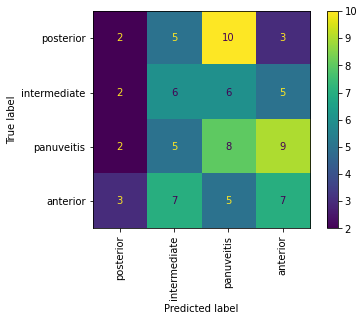

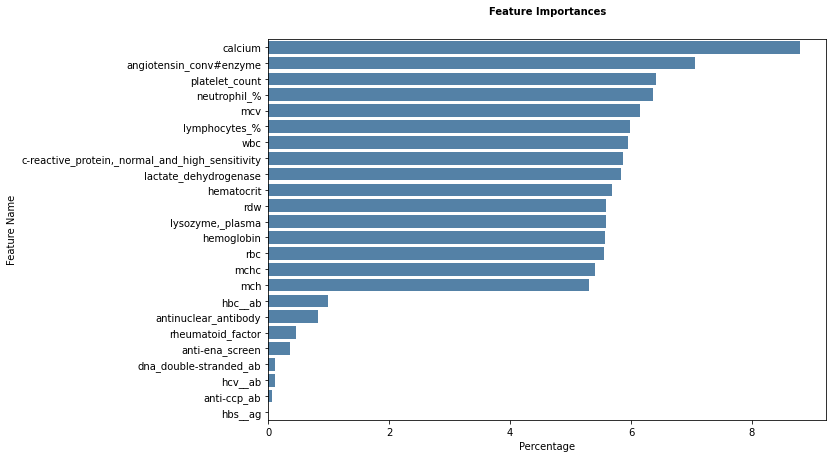

In [19]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.3113964709125999
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.32      0.28      0.30        36
intermediate       0.21      0.12      0.15        25
  panuveitis       0.29      0.26      0.27        31
   posterior       0.40      0.59      0.47        39

    accuracy                           0.34       131
   macro avg       0.30      0.31      0.30       131
weighted avg       0.32      0.34      0.32       131

Standarddeviation Score: 0.05675230070792116


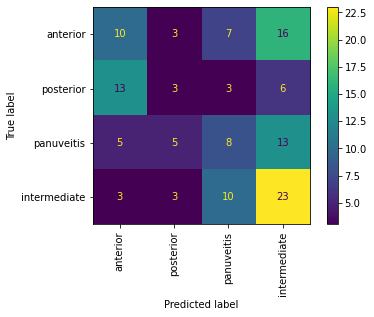

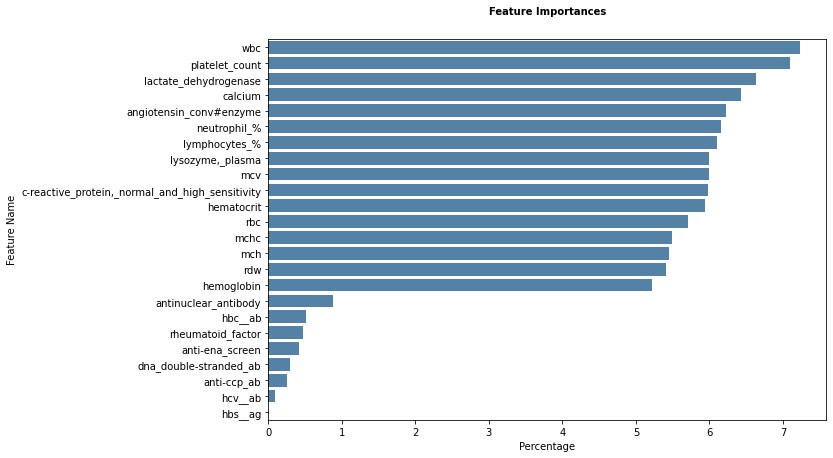

In [20]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.30289812646370023
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 85, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

    anterior       0.31      0.32      0.31        56
intermediate       0.25      0.14      0.18        44
  panuveitis       0.43      0.16      0.24        55
   posterior       0.32      0.59      0.42        61

    accuracy                           0.32       216
   macro avg       0.33      0.30      0.29       216
weighted avg       0.33      0.32      0.29       216

Standarddeviation Score: 0.012210272615685865


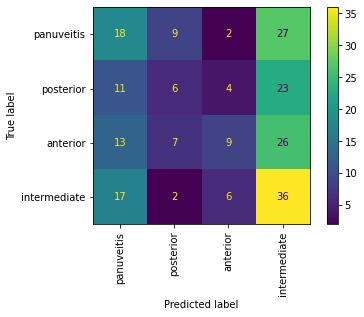

In [21]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.3119019138755981
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

    anterior       0.20      0.25      0.22        20
intermediate       0.27      0.32      0.29        19
  panuveitis       0.46      0.50      0.48        24
   posterior       0.33      0.18      0.24        22

    accuracy                           0.32        85
   macro avg       0.32      0.31      0.31        85
weighted avg       0.32      0.32      0.31        85

Standarddeviation Score: 0.017747554015927678


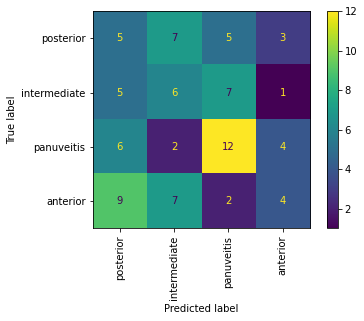

In [22]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.3321264130135098
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

    anterior       0.33      0.53      0.40        36
intermediate       0.27      0.12      0.17        25
  panuveitis       0.35      0.19      0.25        31
   posterior       0.42      0.49      0.45        39

    accuracy                           0.36       131
   macro avg       0.34      0.33      0.32       131
weighted avg       0.35      0.36      0.34       131

Standarddeviation Score: 0.05047998457806226


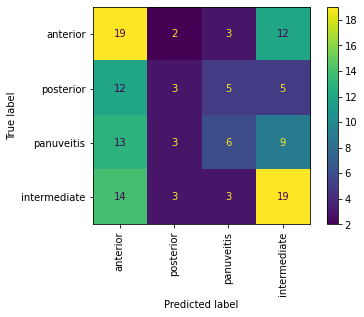

In [23]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.2353789652969981
Best Parameters:
{'svc__C': 2.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.20      0.14      0.16        56
intermediate       0.19      0.32      0.24        44
  panuveitis       0.22      0.22      0.22        55
   posterior       0.33      0.26      0.29        61

    accuracy                           0.23       216
   macro avg       0.23      0.24      0.23       216
weighted avg       0.24      0.23      0.23       216

Standarddeviation Score: 0.022997819370889055


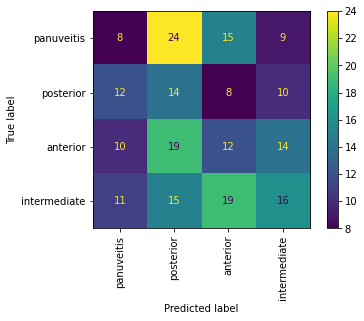

In [24]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.3008971291866029
Best Parameters:
{'svc__C': 1.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.33      0.20      0.25        20
intermediate       0.24      0.53      0.33        19
  panuveitis       0.38      0.25      0.30        24
   posterior       0.31      0.23      0.26        22

    accuracy                           0.29        85
   macro avg       0.32      0.30      0.29        85
weighted avg       0.32      0.29      0.29        85

Standarddeviation Score: 0.018424375232399277


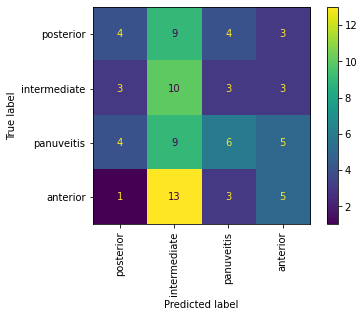

In [25]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.27932726771436445
Best Parameters:
{'svc__C': 0.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'sigmoid'}
              precision    recall  f1-score   support

    anterior       0.28      0.22      0.25        36
intermediate       0.16      0.24      0.19        25
  panuveitis       0.22      0.19      0.21        31
   posterior       0.47      0.46      0.47        39

    accuracy                           0.29       131
   macro avg       0.28      0.28      0.28       131
weighted avg       0.30      0.29      0.29       131

Standarddeviation Score: 0.028038149515964596


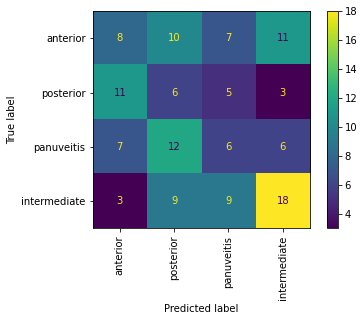

In [26]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.27238662976367894
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
              precision    recall  f1-score   support

    anterior       0.30      0.21      0.25        56
intermediate       0.19      0.14      0.16        44
  panuveitis       0.25      0.35      0.29        55
   posterior       0.35      0.39      0.37        61

    accuracy                           0.28       216
   macro avg       0.27      0.27      0.27       216
weighted avg       0.28      0.28      0.28       216

Standarddeviation Score: 0.01733843467709206


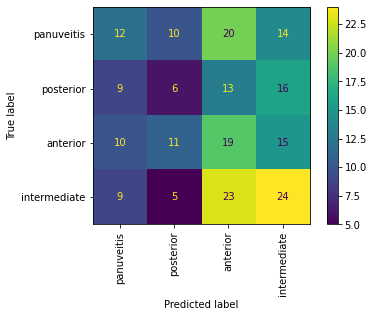

In [27]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.30139553429027116
Best Parameters:
{'mlp__hidden_layer_sizes': (15, 10)}
              precision    recall  f1-score   support

    anterior       0.36      0.20      0.26        20
intermediate       0.18      0.26      0.21        19
  panuveitis       0.38      0.33      0.36        24
   posterior       0.36      0.41      0.38        22

    accuracy                           0.31        85
   macro avg       0.32      0.30      0.30        85
weighted avg       0.33      0.31      0.31        85

Standarddeviation Score: 0.010896273980096847


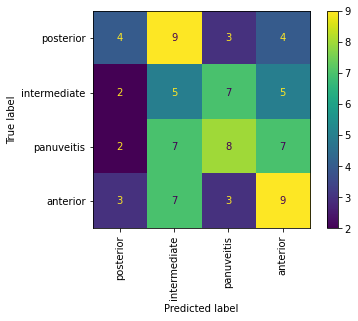

In [28]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.3249345188861318
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
              precision    recall  f1-score   support

    anterior       0.37      0.36      0.37        36
intermediate       0.28      0.20      0.23        25
  panuveitis       0.32      0.23      0.26        31
   posterior       0.36      0.51      0.42        39

    accuracy                           0.34       131
   macro avg       0.33      0.32      0.32       131
weighted avg       0.34      0.34      0.33       131

Standarddeviation Score: 0.045773462382579344


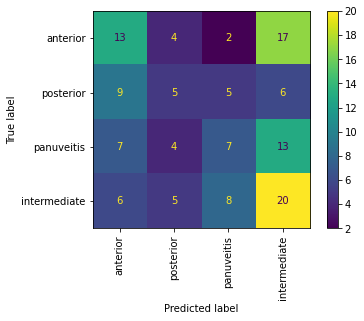

In [29]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.2861068235043645
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 2, 'xgb__n_estimators': 20}
              precision    recall  f1-score   support

    anterior       0.34      0.34      0.34        56
intermediate       0.30      0.20      0.24        44
  panuveitis       0.25      0.27      0.26        55
   posterior       0.29      0.33      0.31        61

    accuracy                           0.29       216
   macro avg       0.29      0.29      0.29       216
weighted avg       0.29      0.29      0.29       216

Standarddeviation Score: 0.019373338727724076


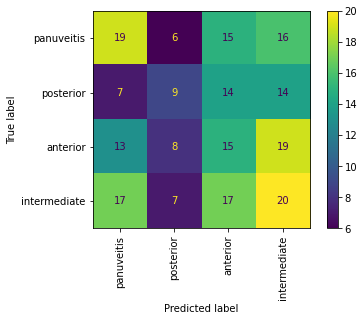

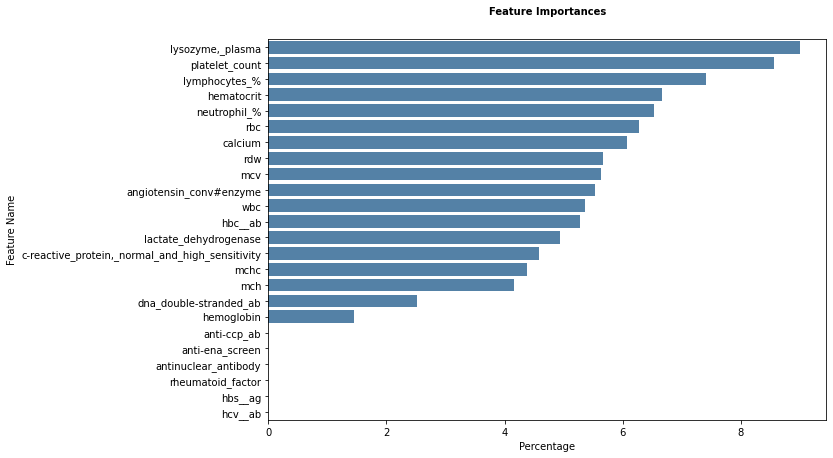

In [30]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)


xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.31294856459330145
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 2, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

    anterior       0.36      0.25      0.29        20
intermediate       0.29      0.26      0.28        19
  panuveitis       0.26      0.38      0.31        24
   posterior       0.42      0.36      0.39        22

    accuracy                           0.32        85
   macro avg       0.33      0.31      0.32        85
weighted avg       0.33      0.32      0.32        85

Standarddeviation Score: 0.016668824252846746


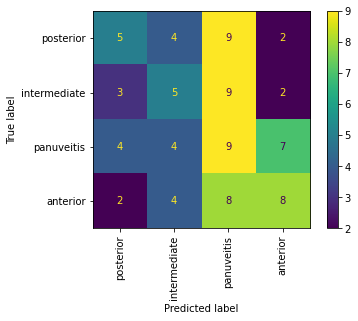

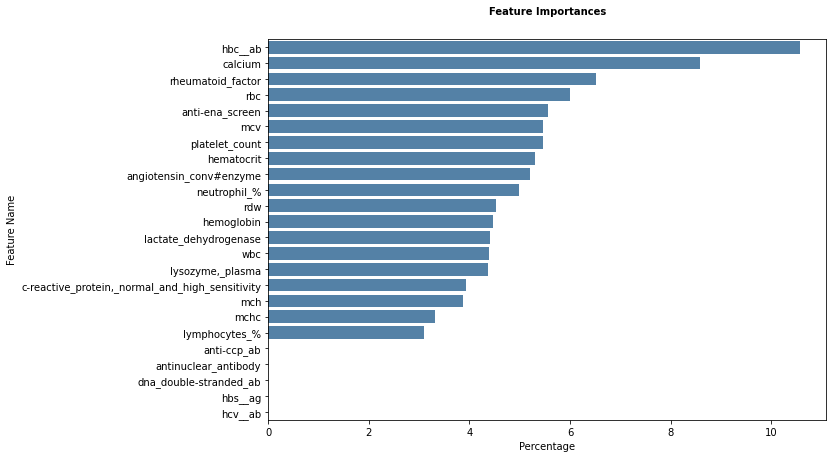

In [31]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.3121781086297215
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 2, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

    anterior       0.34      0.44      0.39        36
intermediate       0.17      0.04      0.06        25
  panuveitis       0.28      0.23      0.25        31
   posterior       0.40      0.54      0.46        39

    accuracy                           0.34       131
   macro avg       0.30      0.31      0.29       131
weighted avg       0.31      0.34      0.31       131

Standarddeviation Score: 0.006232798327692553


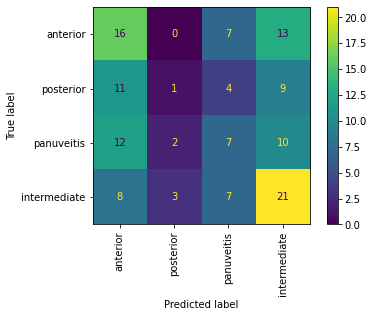

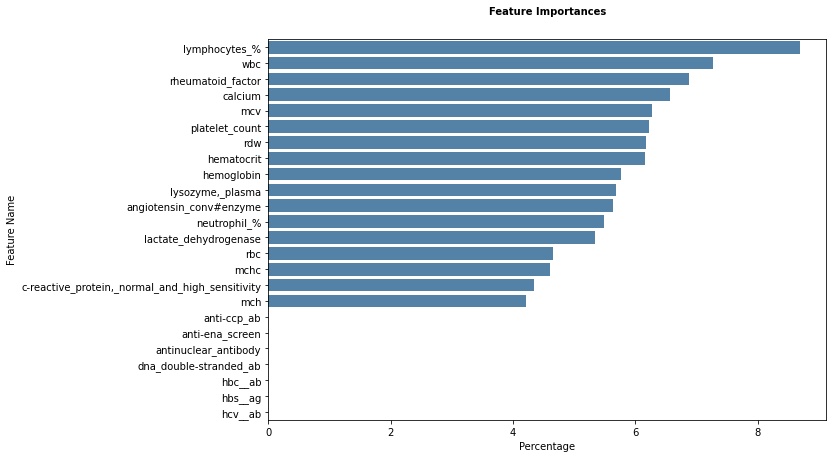

In [32]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.24763146689376198
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 10, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.34      0.36      0.35        56
intermediate       0.24      0.18      0.21        44
  panuveitis       0.10      0.09      0.09        55
   posterior       0.30      0.36      0.33        61

    accuracy                           0.25       216
   macro avg       0.24      0.25      0.24       216
weighted avg       0.25      0.25      0.25       216

Standarddeviation Score: 0.02722724956885788


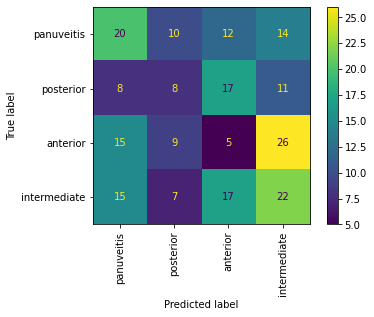

In [33]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    #plot_featureimportance(bv.best_estimator_)

    
ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.23151913875598085
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 4, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.19      0.20      0.20        20
intermediate       0.19      0.16      0.17        19
  panuveitis       0.26      0.25      0.26        24
   posterior       0.28      0.32      0.30        22

    accuracy                           0.24        85
   macro avg       0.23      0.23      0.23        85
weighted avg       0.23      0.24      0.23        85

Standarddeviation Score: 0.024346662601040774


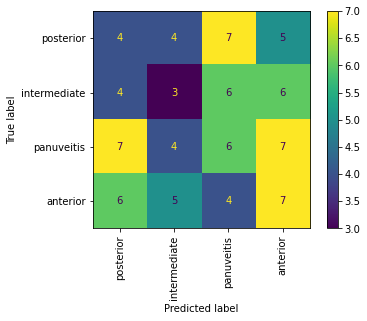

In [34]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.2870588640749931
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 2, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 50}
              precision    recall  f1-score   support

    anterior       0.30      0.31      0.30        36
intermediate       0.17      0.20      0.19        25
  panuveitis       0.29      0.26      0.27        31
   posterior       0.41      0.38      0.39        39

    accuracy                           0.30       131
   macro avg       0.29      0.29      0.29       131
weighted avg       0.30      0.30      0.30       131

Standarddeviation Score: 0.02188886836397614


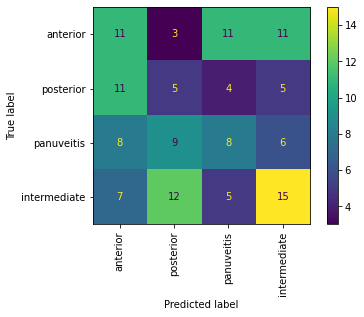

In [35]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)

# Binary classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the mulitclass classification (see chapter above)

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [36]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'binary',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

gender                loc  calcium  lactate_dehydrogenase  \
0    Male   anterior_segment     2.27                    184   
1  Female  posterior_segment     2.32                    209   
2  Female  posterior_segment     2.44                    194   
3  Female   anterior_segment     2.45                    156   
4  Female   anterior_segment     2.28                    175   

   c-reactive_protein,_normal_and_high_sensitivity   wbc   rbc  hemoglobin  \
0                                             1.83  6.91  4.97        14.6   
1                                             0.15  4.24  4.22        11.0   
2                                            0.137  6.38  4.31        13.6   
3                                              3.5  5.24  4.82        14.6   
4                                              1.0  8.31  4.72        14.0   

   hematocrit   mcv  ...  lysozyme,_plasma  anti-ccp_ab  anti-ena_screen  \
0        41.4  83.3  ...               3.0          0.0              0.0   
1        36.0  85.3  ...              <NA>          0.0              0.0   
2        38.7  89.8  ...               4.8          0.0              0.0   
3        43.6  90.5  ...              <NA>          0.0              0.0   
4        40.7  86.2  ...               4.5          0.0              0.0   

   antinuclear_antibody  dna_double-stranded_ab  rheumatoid_factor  hbc__ab  \
0                   0.0                     0.0                  0        0   
1                   0.0                     0.0                  0        0   
2                   0.0                     0.0                  0        0   
3                   0.0                     0.0                  0        0   
4                   0.0                     1.0                  0        0   

   hbs__ag  hcv__ab  uveitis  
0        0        0    False  
1        0        0     True  
2        0        0     True  
3        0        0     True  
4        0        0     True  

[5 rows x 27 columns]

### Split into uveitis and not_uveitis data

In [37]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

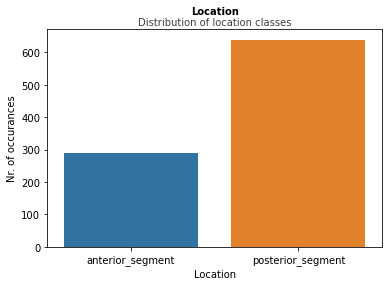

In [38]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes','Location','Nr. of occurances')

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

In [39]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

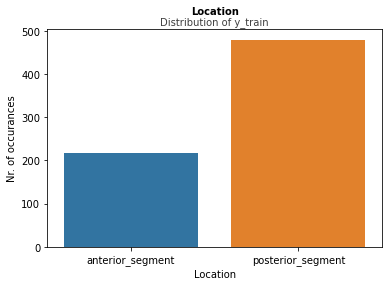

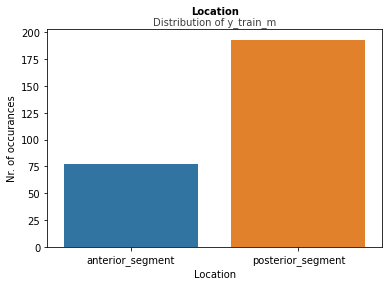

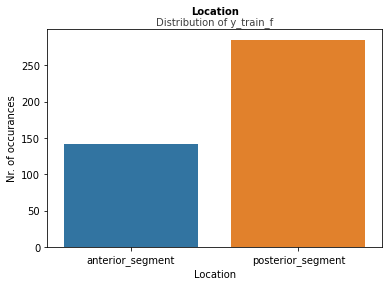

In [40]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

#### Imputation and Encoding

In [41]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_no_onehot # imputer_encoder_onehot yields best results so far 

## 3-Dimensional Data Representation

In [42]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train.values,
                   title="PCA representation of uveitits positive training data", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.55 %


In [43]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_m)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_m.values,
                   title="PCA representation of uveitits positive training data (male only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.44 %


In [44]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_f)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_f.values,
                   title="PCA representation of uveitits positive training data (female only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.92 %


## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [45]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.48818493150684933
Class probabilites: [0.31276901 0.68723099]


### Male positive data

In [46]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.5153846153846153
Class probabilites: [0.28518519 0.71481481]


### Female positive data

In [47]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.5671542553191489
Class probabilites: [0.33098592 0.66901408]


## Decision Tree

### Complete positive data

Score: 0.5422517123287671
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 12, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.36      0.47      0.40        73
posterior_segment       0.72      0.62      0.66       160

         accuracy                           0.57       233
        macro avg       0.54      0.54      0.53       233
     weighted avg       0.60      0.57      0.58       233

Standarddeviation Score: 0.010205745113355804


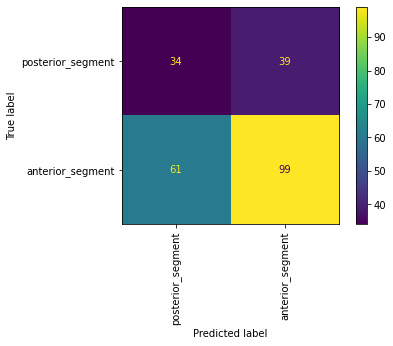

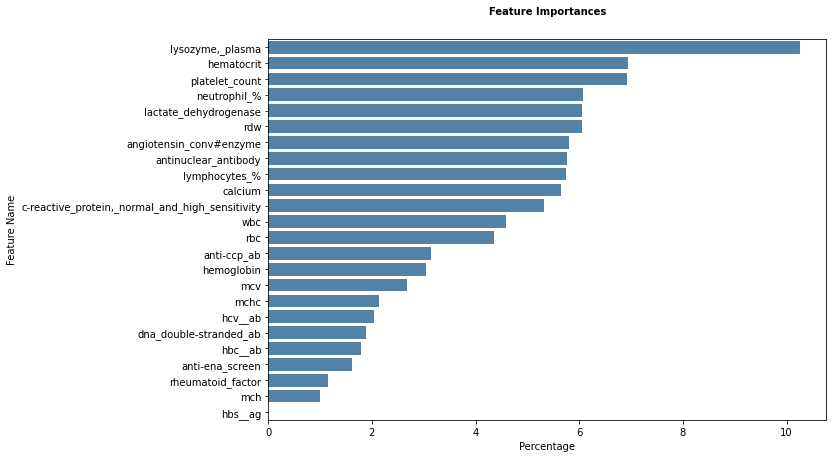

In [48]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    plot_featureimportance(bv.best_estimator_)

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.5307692307692308
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 10, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'best'}
                   precision    recall  f1-score   support

 anterior_segment       0.32      0.38      0.35        26
posterior_segment       0.73      0.68      0.70        65

         accuracy                           0.59        91
        macro avg       0.53      0.53      0.53        91
     weighted avg       0.62      0.59      0.60        91

Standarddeviation Score: 0.061692968221933854


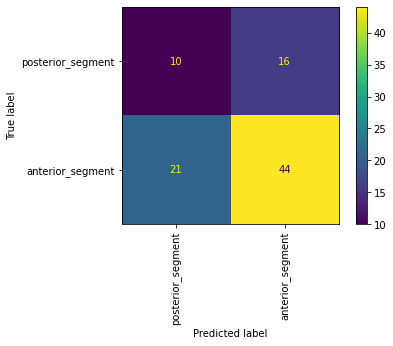

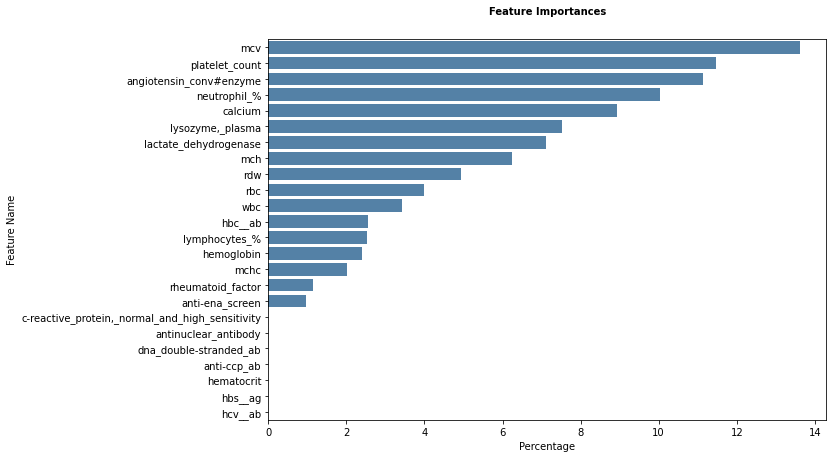

In [49]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5374556737588653
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 14, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.36      0.60      0.45        47
posterior_segment       0.71      0.48      0.57        96

         accuracy                           0.52       143
        macro avg       0.53      0.54      0.51       143
     weighted avg       0.59      0.52      0.53       143

Standarddeviation Score: 0.0710705698815872


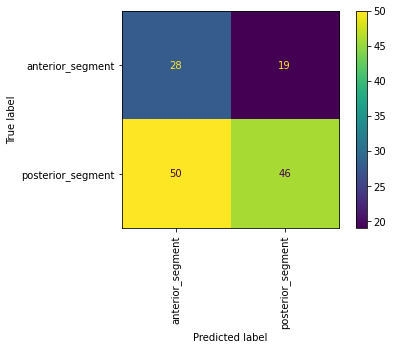

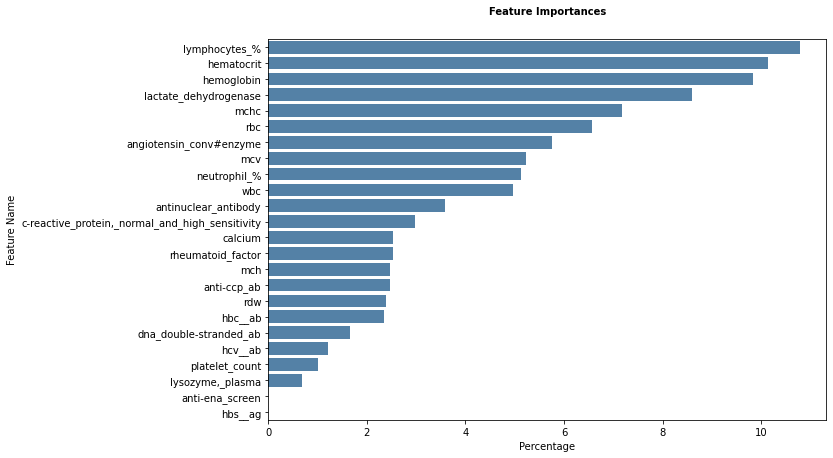

In [50]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.5098458904109588
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.08      0.13        73
posterior_segment       0.69      0.94      0.80       160

         accuracy                           0.67       233
        macro avg       0.53      0.51      0.47       233
     weighted avg       0.59      0.67      0.59       233

Standarddeviation Score: 0.01170993780464749


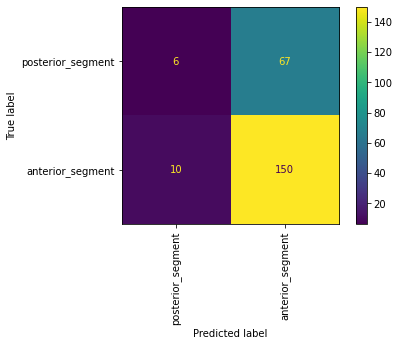

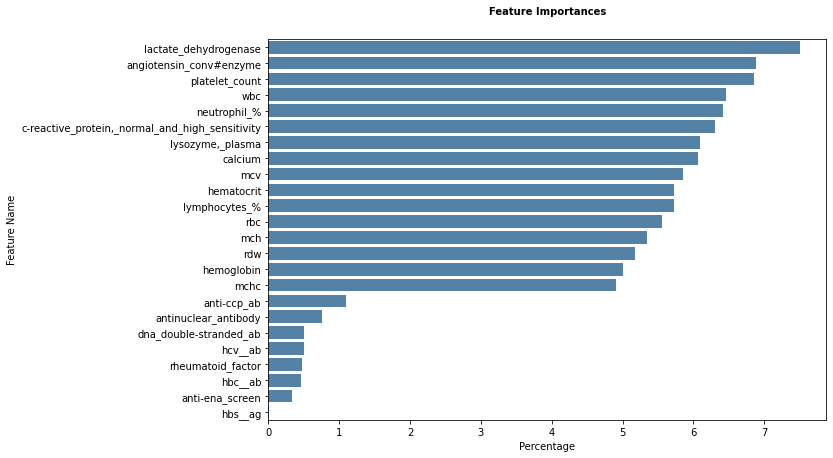

In [51]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)


    
ran_tree(X_train, X_test, y_train, y_test)

In [52]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.5
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.29      0.08      0.12        26
posterior_segment       0.71      0.92      0.81        65

         accuracy                           0.68        91
        macro avg       0.50      0.50      0.46        91
     weighted avg       0.59      0.68      0.61        91

Standarddeviation Score: 0.021870203522232703


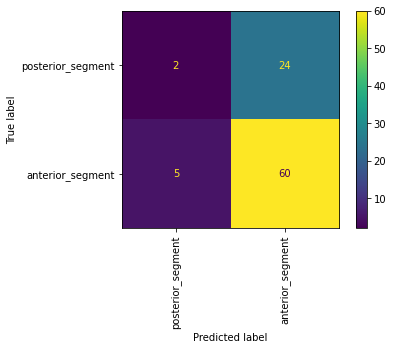

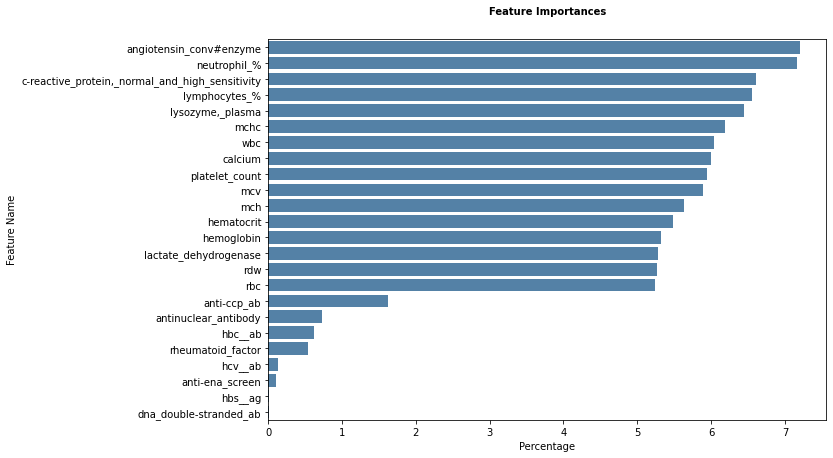

In [53]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5221631205673759
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.43      0.13      0.20        47
posterior_segment       0.68      0.92      0.78        96

         accuracy                           0.66       143
        macro avg       0.56      0.52      0.49       143
     weighted avg       0.60      0.66      0.59       143

Standarddeviation Score: 0.026586463610491287


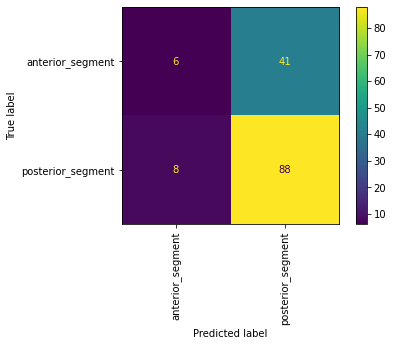

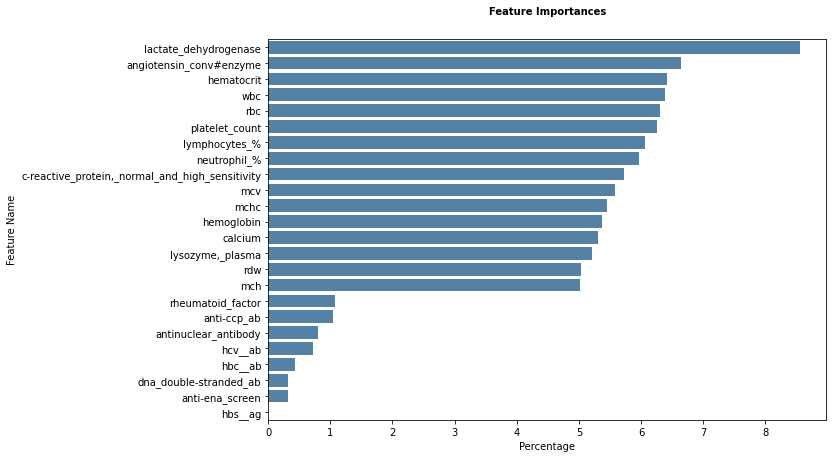

In [54]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.5615154109589041
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.56      0.19      0.29        73
posterior_segment       0.72      0.93      0.81       160

         accuracy                           0.70       233
        macro avg       0.64      0.56      0.55       233
     weighted avg       0.67      0.70      0.65       233

Standarddeviation Score: 0.017335381485975042


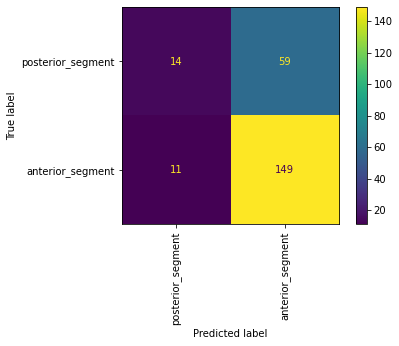

In [55]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.5384615384615384
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.23      0.29        26
posterior_segment       0.73      0.85      0.79        65

         accuracy                           0.67        91
        macro avg       0.55      0.54      0.54        91
     weighted avg       0.63      0.67      0.64        91

Standarddeviation Score: 0.017386709021546733


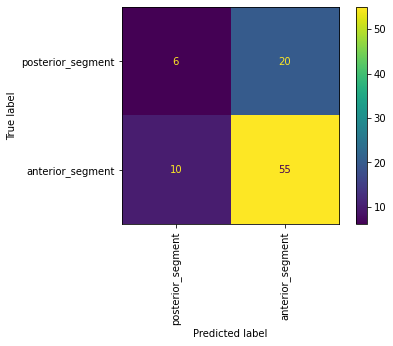

In [56]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.49224290780141844
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.32      0.26      0.28        47
posterior_segment       0.67      0.73      0.70        96

         accuracy                           0.57       143
        macro avg       0.49      0.49      0.49       143
     weighted avg       0.55      0.57      0.56       143

Standarddeviation Score: 0.03343010605755985


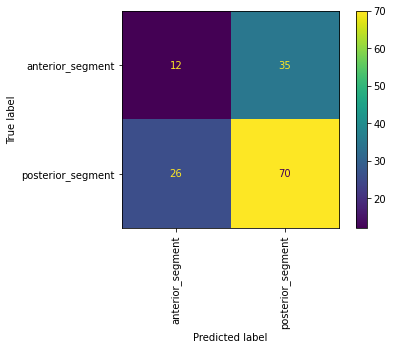

In [57]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.516652397260274
Best Parameters:
{'svc__C': 0.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.33      0.45      0.38        73
posterior_segment       0.70      0.58      0.63       160

         accuracy                           0.54       233
        macro avg       0.51      0.52      0.51       233
     weighted avg       0.58      0.54      0.56       233

Standarddeviation Score: 0.02341665776647836


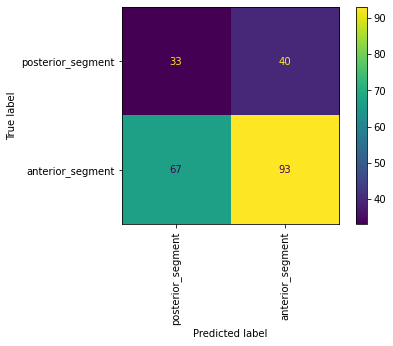

In [58]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.5076923076923077
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'linear'}
                   precision    recall  f1-score   support

 anterior_segment       0.29      0.54      0.38        26
posterior_segment       0.72      0.48      0.57        65

         accuracy                           0.49        91
        macro avg       0.51      0.51      0.48        91
     weighted avg       0.60      0.49      0.52        91

Standarddeviation Score: 0.03146710416937107


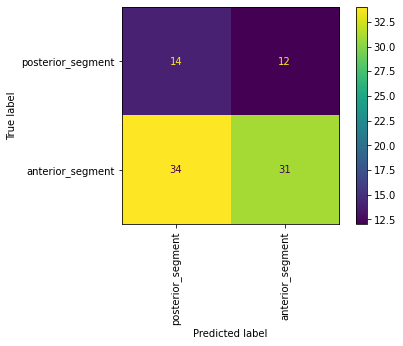

In [59]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5205008865248226
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.35      0.47      0.40        47
posterior_segment       0.69      0.57      0.62        96

         accuracy                           0.54       143
        macro avg       0.52      0.52      0.51       143
     weighted avg       0.58      0.54      0.55       143

Standarddeviation Score: 0.020113387005734278


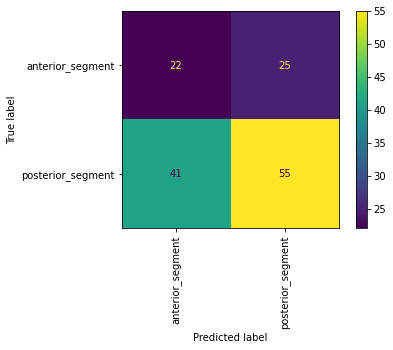

In [60]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.5051369863013698
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.32      0.26      0.29        73
posterior_segment       0.69      0.75      0.72       160

         accuracy                           0.60       233
        macro avg       0.51      0.51      0.50       233
     weighted avg       0.57      0.60      0.58       233

Standarddeviation Score: 0.011500123970127283


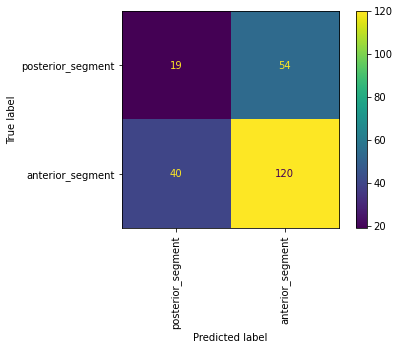

In [61]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.573076923076923
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.41      0.35      0.38        26
posterior_segment       0.75      0.80      0.78        65

         accuracy                           0.67        91
        macro avg       0.58      0.57      0.58        91
     weighted avg       0.66      0.67      0.66        91

Standarddeviation Score: 0.04592048795074068


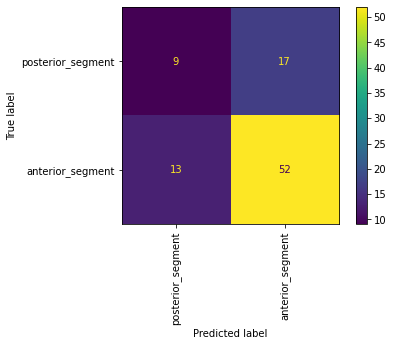

In [62]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.4924645390070922
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.32      0.28      0.30        47
posterior_segment       0.67      0.71      0.69        96

         accuracy                           0.57       143
        macro avg       0.49      0.49      0.49       143
     weighted avg       0.55      0.57      0.56       143

Standarddeviation Score: 0.015520014649340783


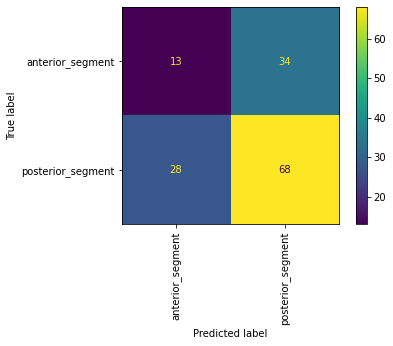

In [63]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.5571917808219178
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 7, 'xgb__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.60      0.16      0.26        73
posterior_segment       0.71      0.95      0.82       160

         accuracy                           0.70       233
        macro avg       0.66      0.56      0.54       233
     weighted avg       0.68      0.70      0.64       233

Standarddeviation Score: 0.03264582312649424


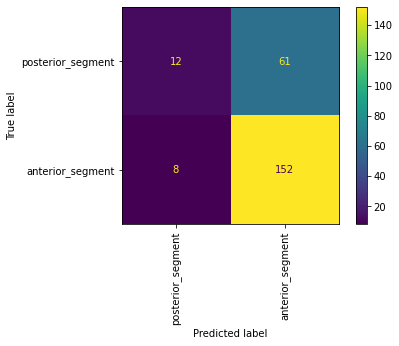

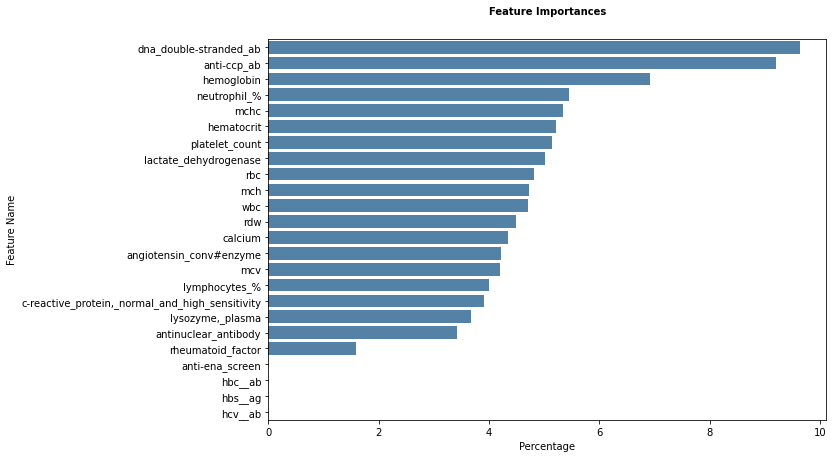

In [64]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.49615384615384617
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.27      0.12      0.16        26
posterior_segment       0.71      0.88      0.79        65

         accuracy                           0.66        91
        macro avg       0.49      0.50      0.47        91
     weighted avg       0.59      0.66      0.61        91

Standarddeviation Score: 0.04969145198144904


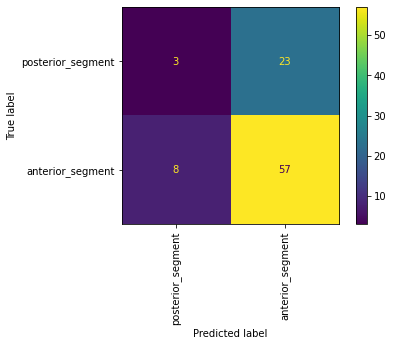

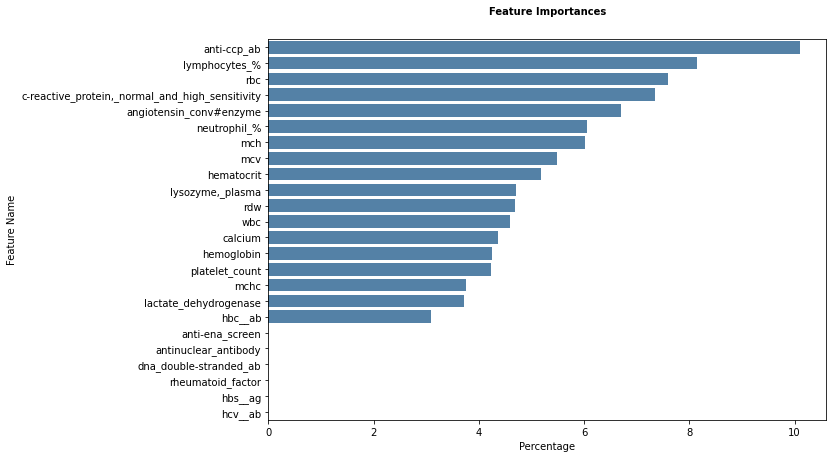

In [65]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.4859264184397163
Best Parameters:
{'xgb__colsample_bytree': 0.3, 'xgb__max_depth': 7, 'xgb__n_estimators': 20}
                   precision    recall  f1-score   support

 anterior_segment       0.29      0.15      0.20        47
posterior_segment       0.66      0.82      0.73        96

         accuracy                           0.60       143
        macro avg       0.48      0.49      0.47       143
     weighted avg       0.54      0.60      0.56       143

Standarddeviation Score: 0.01016442613228076


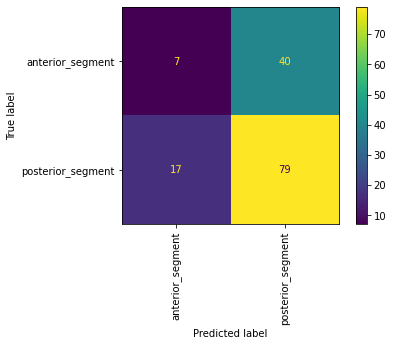

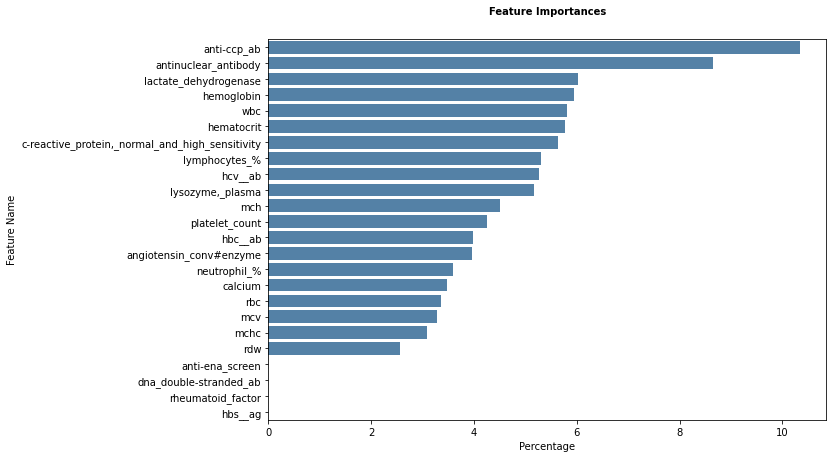

In [66]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.5194349315068494
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 6, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.34      0.30      0.32        73
posterior_segment       0.70      0.74      0.72       160

         accuracy                           0.60       233
        macro avg       0.52      0.52      0.52       233
     weighted avg       0.59      0.60      0.59       233

Standarddeviation Score: 0.01808571886667357


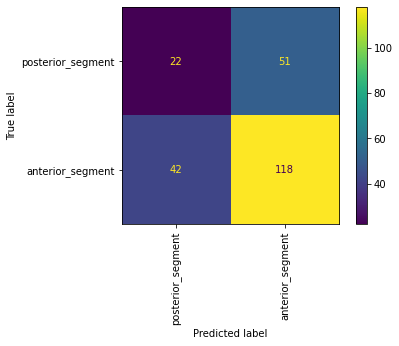

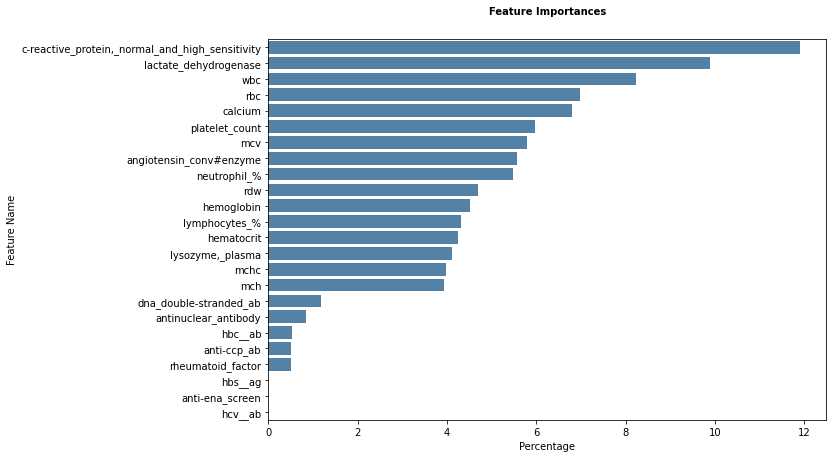

In [67]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.5461538461538462
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 10, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.40      0.23      0.29        26
posterior_segment       0.74      0.86      0.79        65

         accuracy                           0.68        91
        macro avg       0.57      0.55      0.54        91
     weighted avg       0.64      0.68      0.65        91

Standarddeviation Score: 0.01526973248734383


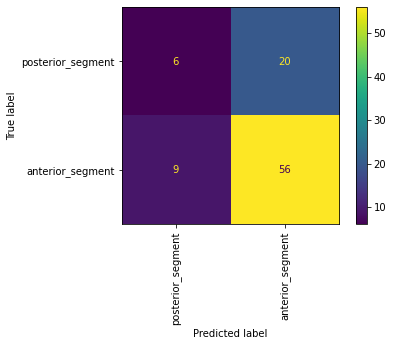

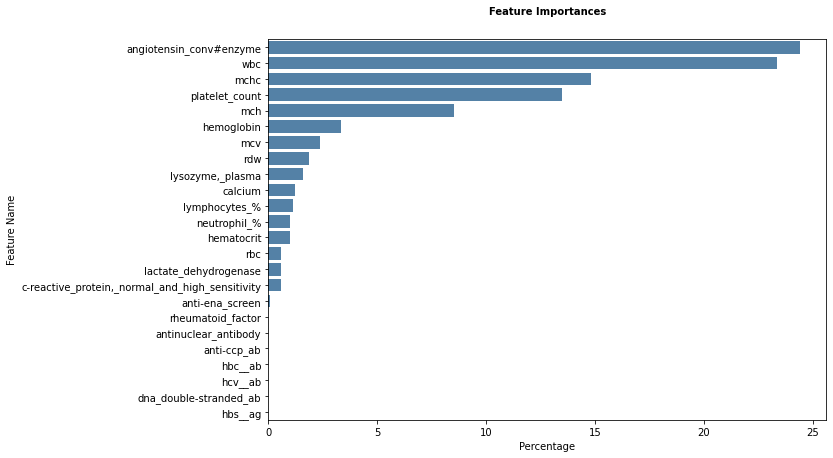

In [68]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.43406471631205673
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 4, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 25}
                   precision    recall  f1-score   support

 anterior_segment       0.22      0.17      0.19        47
posterior_segment       0.63      0.70      0.66        96

         accuracy                           0.52       143
        macro avg       0.42      0.43      0.43       143
     weighted avg       0.50      0.52      0.51       143

Standarddeviation Score: 0.08064707424038618


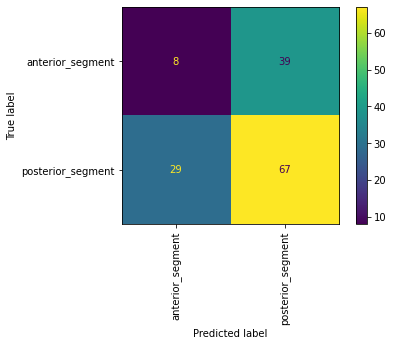

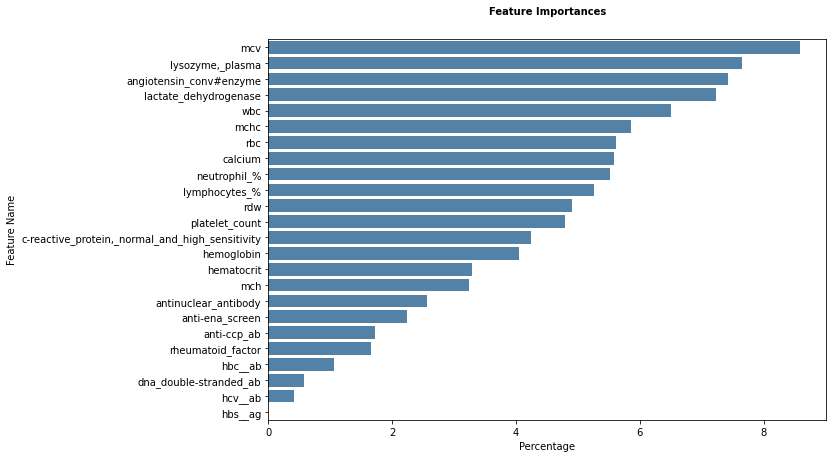

In [69]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)

# One vs. All Location Prediction
In this section we try to identify importent lab tests for a location. For this train a model for every single location and mask every other location as "other". For easy interpretability and feature extraction we restrain ourselfs to tree based algorithmns.

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [70]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

gender           loc  calcium  lactate_dehydrogenase  \
0    Male      anterior     2.27                    184   
1  Female  intermediate     2.32                    209   
2  Female    panuveitis     2.44                    194   
3  Female      anterior     2.45                    156   
4  Female      anterior     2.28                    175   

   c-reactive_protein,_normal_and_high_sensitivity   wbc   rbc  hemoglobin  \
0                                             1.83  6.91  4.97        14.6   
1                                             0.15  4.24  4.22        11.0   
2                                            0.137  6.38  4.31        13.6   
3                                              3.5  5.24  4.82        14.6   
4                                              1.0  8.31  4.72        14.0   

   hematocrit   mcv  ...  lysozyme,_plasma  anti-ccp_ab  anti-ena_screen  \
0        41.4  83.3  ...               3.0          0.0              0.0   
1        36.0  85.3  ...              <NA>          0.0              0.0   
2        38.7  89.8  ...               4.8          0.0              0.0   
3        43.6  90.5  ...              <NA>          0.0              0.0   
4        40.7  86.2  ...               4.5          0.0              0.0   

   antinuclear_antibody  dna_double-stranded_ab  rheumatoid_factor  hbc__ab  \
0                   0.0                     0.0                  0        0   
1                   0.0                     0.0                  0        0   
2                   0.0                     0.0                  0        0   
3                   0.0                     0.0                  0        0   
4                   0.0                     1.0                  0        0   

   hbs__ag  hcv__ab  uveitis  
0        0        0    False  
1        0        0     True  
2        0        0     True  
3        0        0     True  
4        0        0     True  

[5 rows x 27 columns]

### Split into uveitis and not_uveitis data

In [71]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

In [72]:
df_uv_pos.dropna(subset=['loc'], inplace=True)

In [73]:
def df_one_loc(df, i):
    df_one_vs_all = df.copy()
    df_one_vs_all['loc'] = np.where(df['loc'] != i, "other", df_uv_pos['loc'])
    return df_one_vs_all

df_pos_anterior = df_one_loc(df_uv_pos, 'anterior')
df_pos_intermediate = df_one_loc(df_uv_pos, 'intermediate')
df_pos_panuveitis = df_one_loc(df_uv_pos, 'panuveitis')
df_pos_posterior = df_one_loc(df_uv_pos, 'posterior')
df_pos_scleritis = df_one_loc(df_uv_pos, 'scleritis')

#### Train Test Split

In [74]:
def split_one_loc(df):
    X = df.drop(columns=['loc','uveitis','gender'])
    y = df['loc']
    return train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)

X_train_anterior, X_test_anterior, y_train_anterior, y_test_anterior = split_one_loc(df_pos_anterior)
X_train_intermediate, X_test_intermediate, y_train_intermediate, y_test_intermediate = split_one_loc(df_pos_intermediate)
X_train_panuveitis, X_test_panuveitis, y_train_panuveitis, y_test_panuveitis = split_one_loc(df_pos_panuveitis)
X_train_posterior, X_test_posterior, y_train_posterior, y_test_posterior = split_one_loc(df_pos_posterior)
X_train_scleritis, X_test_scleritis, y_train_scleritis, y_test_scleritis = split_one_loc(df_pos_scleritis)

In [75]:
X_train_anterior.hbc__ab.unique()

[0, 1, NaN]
Categories (2, int64): [0, 1]

#### Imputation and Encoding

In [76]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool', 'object']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_no_onehot # imputer_encoder_onehot yields best results so far 

## 3-Dimensional Data Representation

In [77]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_anterior)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_anterior.values,
                   title="PCA representation of uveitits positive training data (Anterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.78 %


In [78]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_intermediate)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_intermediate.values,
                   title="PCA representation of uveitits positive training data (Intermediate vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.2 %


In [79]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_panuveitis)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_panuveitis.values,
                   title="PCA representation of uveitits positive training data (panuveitis vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.63 %


In [80]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_posterior)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_posterior.values,
                   title="PCA representation of uveitits positive training data (posterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.85 %


In [81]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_scleritis)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_scleritis.values,
                   title="PCA representation of uveitits positive training data (Anterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.32 %


## XGBoost

<AxesSubplot:xlabel='loc', ylabel='count'>

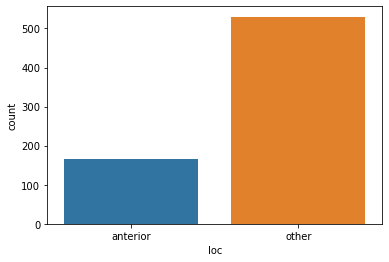

In [82]:
sns.countplot(x=y_train_anterior)

In [83]:
lab = LabelEncoder()
y_train_anterior_enc, y_test_anterior_enc = lab.fit_transform(y_train_anterior), lab.transform(y_test_anterior)
y_train_intermediate_enc, y_test_intermediate_enc = lab.fit_transform(y_train_intermediate), lab.transform(y_test_intermediate)
y_train_panuveitis_enc, y_test_panuveitis_enc = lab.fit_transform(y_train_panuveitis), lab.transform(y_test_panuveitis)
y_train_posterior_enc, y_test_posterior_enc = lab.fit_transform(y_train_posterior), lab.transform(y_test_posterior)
y_train_scleritis_enc, y_test_scleritis_enc = lab.fit_transform(y_train_scleritis), lab.transform(y_test_scleritis)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.5159402744148507
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 5, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

           0       0.36      0.07      0.12        56
           1       0.77      0.96      0.85       177

    accuracy                           0.75       233
   macro avg       0.56      0.52      0.49       233
weighted avg       0.67      0.75      0.68       233

Standarddeviation Score: 0.0020080633539136064


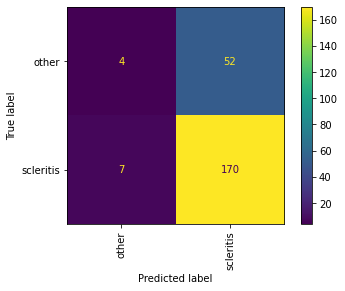

In [84]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20,40,60]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0, use_label_encoder=False)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=lab.classes_,
                          xticks_rotation='vertical');
    
    return bv.best_estimator_
    
xgb_anterior = xgb_model(X_train_anterior, X_test_anterior, y_train_anterior_enc, y_test_anterior_enc)

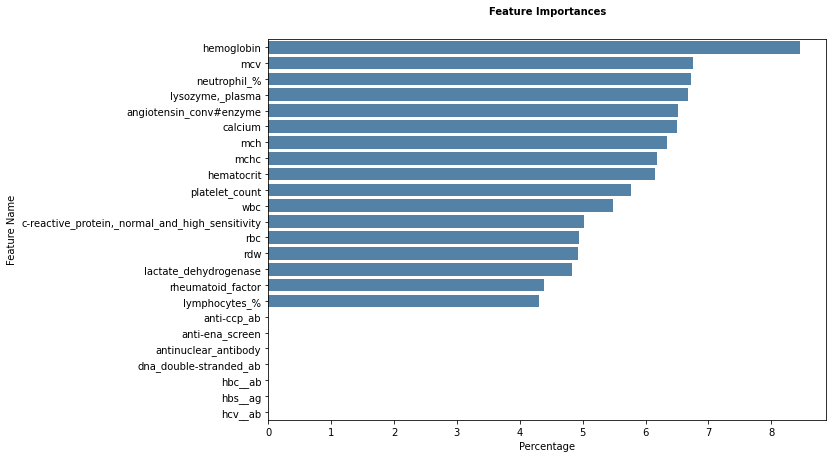

In [85]:
plot_featureimportance(xgb_anterior)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.4656084656084656
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 5, 'xgb__n_estimators': 60}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.80      0.93      0.86       189

    accuracy                           0.76       233
   macro avg       0.40      0.47      0.43       233
weighted avg       0.65      0.76      0.70       233

Standarddeviation Score: 0.014991172572974403


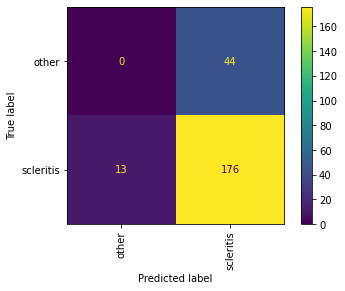

In [86]:
xgb_intermediate = xgb_model(X_train_intermediate, X_test_intermediate, y_train_intermediate_enc, y_test_intermediate_enc)

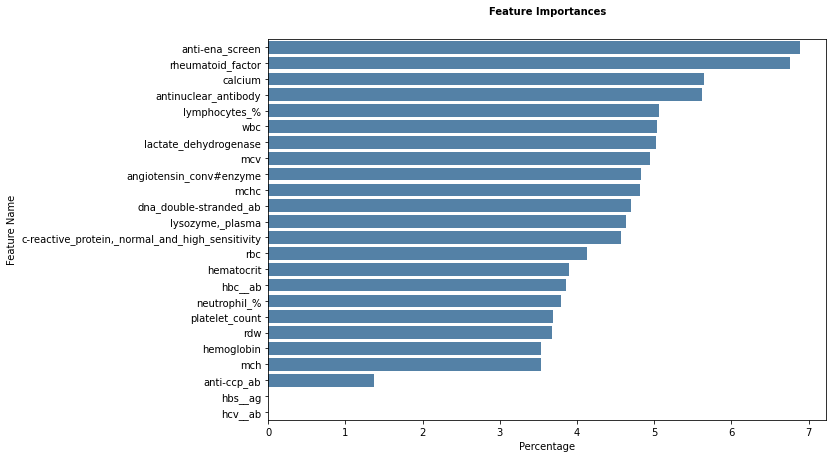

In [87]:
plot_featureimportance(xgb_intermediate)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.5033197139938713
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 7, 'xgb__n_estimators': 40}
              precision    recall  f1-score   support

           0       0.77      0.92      0.83       178
           1       0.25      0.09      0.13        55

    accuracy                           0.72       233
   macro avg       0.51      0.50      0.48       233
weighted avg       0.64      0.72      0.67       233

Standarddeviation Score: 0.018934122530386097


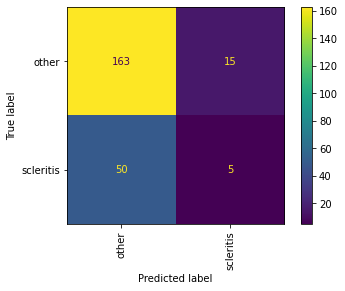

In [88]:
xgb_panuveitis = xgb_model(X_train_panuveitis, X_test_panuveitis, y_train_panuveitis_enc, y_test_panuveitis_enc)

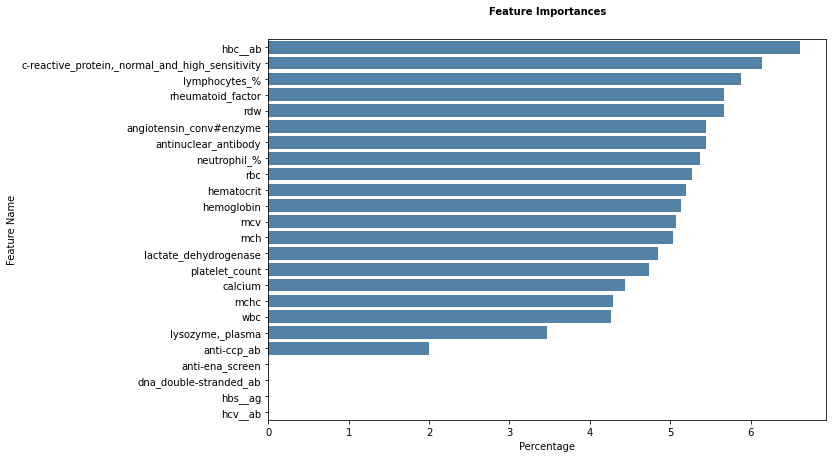

In [89]:
plot_featureimportance(xgb_panuveitis)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.5388867708730462
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 2, 'xgb__n_estimators': 60}
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       172
           1       0.43      0.15      0.22        61

    accuracy                           0.73       233
   macro avg       0.59      0.54      0.53       233
weighted avg       0.67      0.73      0.67       233

Standarddeviation Score: 0.017090432208575517


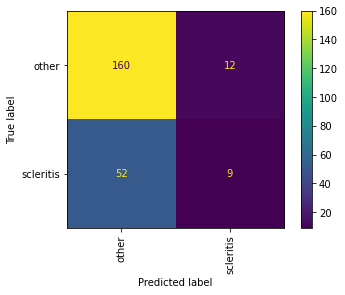

In [90]:
xgb_posterior = xgb_model(X_train_posterior, X_test_posterior, y_train_posterior_enc, y_test_posterior_enc)

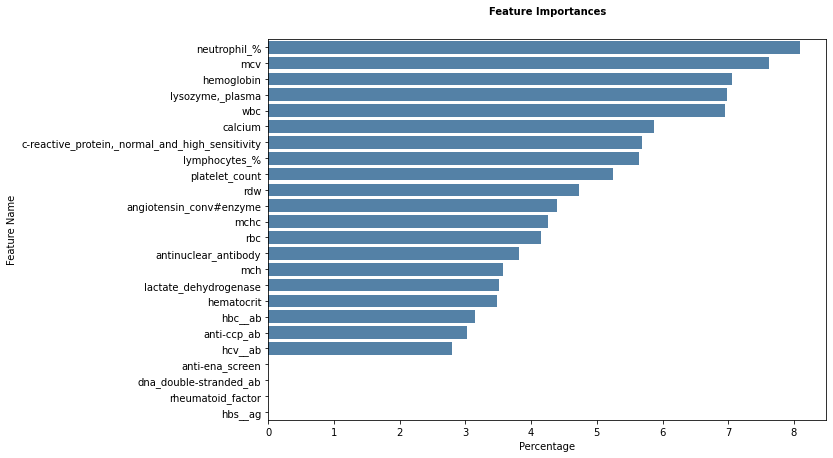

In [91]:
plot_featureimportance(xgb_posterior)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Score: 0.5
Best Parameters:
{'xgb__colsample_bytree': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 60}
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       216
           1       0.00      0.00      0.00        17

    accuracy                           0.93       233
   macro avg       0.46      0.50      0.48       233
weighted avg       0.86      0.93      0.89       233

Standarddeviation Score: 0.0


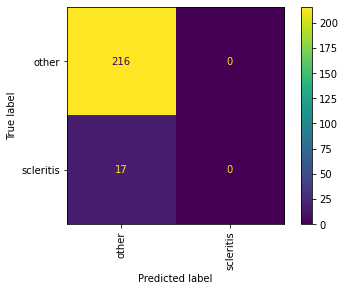

In [92]:
xgb_scleritis = xgb_model(X_train_scleritis, X_test_scleritis, y_train_scleritis_enc, y_test_scleritis_enc)

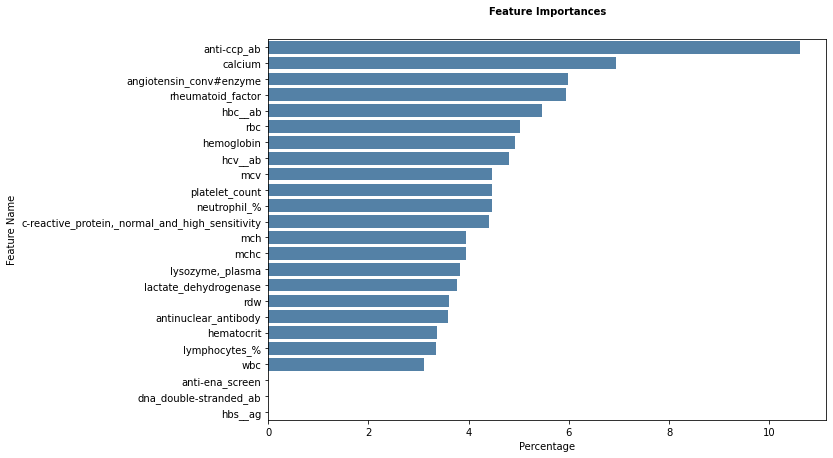

In [93]:
plot_featureimportance(xgb_scleritis)